# Lab 7: Conflict Monitoring, Effort, & Control

Humans are motivationally omnivorous -- from wanting to catch a fish to wanting to walk on the moon.  Accomplishing open-ended goals that can span days to lifetimes requires ... did you just get an email notification?  Go ahead, check your phone, this notebook is very patient... now you're back ... requires a cognitive architecture capable overcoming interuptions, sustaining effort, and controlling attention.  These abilities comprise the will of free will.  

Around the start of the semester you freely decided to learn about computational modeling of psychological function, and for the most part have willfully followed through.  At times it has been effortless -- when you were captivated by fascinating discoveries, theories, and models.  At other times it has been effortful -- requiring you to suppress a wide variety of distractions and competing interests.  During those effortful moments, when you succeeded in maintaining or regaining focus on the lectures, readings, or lab work, what was happening in your mind? In this lab we will explore the cognitive processes that monitor for internal conflict and help overcome that conflict.  When effort is required to help control attention, mechanisms that monitor conflict can activate effort and control.  For a familiar starting point, we will build a conflict monitoring system on top of a Stroop model introduced in Lab 6.

In [ ]:
!pip install psyneulink
!pip install stroop 

     |████████████████████████████████| 1.3MB 5.9MB/s 
     |████████████████████████████████| 204kB 22.2MB/s 
     |████████████████████████████████| 776.8MB 21kB/s 
     |████████████████████████████████| 122kB 46.4MB/s 
     |████████████████████████████████| 2.5MB 36.4MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 1.0MB 36.9MB/s 
     |████████████████████████████████| 204kB 44.8MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
     |████████████████████████████████| 686kB 45.7MB/s 
  Created wheel for typecheck-decorator: filename=typecheck_decorator-1.2-cp37-none-any.whl size=16879 sha256=02552c86d87faf24a00e5a5f95d7762490ccd4807af15eaf1e93ffa6952d3d79
  Stored in directory: /root/.cache/pip/wheels/ef/12/5a/fd05ccc14a1471b48e92c86ef837164eeeb26d80acdf2084f3
  Created wheel for GPy: filename=GPy-1.9.9-cp37-cp37m-linux_x86_64.whl size=2626968 sha256=19e33a9c8942e5d74274d68c0a377707f2ab56a722b1d7076bb851de9af4e547
  Stor

## <a id='table'>Table of contents </a> 

#### Models 
- [1. Setup, the stroop model and the task stimuli](#s1)
- [2. Decision activity](#s2)
- [3. Decision energy](#s3)
- [4. Task demand](#s4)


#### Lab exercises 
- [1. Setting Expectations](#l1)
- [2. Visualize the activity time course for the hidden layers on a green trial](#l2)
- [3. Energy, the initial state](#l3)
- [4. Interpret the task demand results above](#l4)
- [5. Putting it all together](#l5)
- [6. BUILD](#l6)

In [ ]:
import os
import time
import numpy as np
import psyneulink as pnl 

import stroop
from stroop.stimulus import get_stimulus_set, TASKS, COLORS, CONDITIONS

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

sns.set(style='white', context='talk', palette="colorblind")
np.random.seed(0)

%matplotlib inline 
%autosave 5

Autosaving every 5 seconds


In [ ]:
# constants
experiment_info = f"""
stroop experiment info
- all colors:\t {COLORS}
- all words:\t {COLORS}
- all tasks:\t {TASKS}
- all conditions:{CONDITIONS}
"""
print(experiment_info)

# calculate experiment metadata
n_conditions = len(CONDITIONS)
n_tasks = len(TASKS)
n_colors = len(COLORS)

# OTHER CONSTANTS
N_UNITS = 2


stroop experiment info
- all colors:	 ['red', 'green']
- all words:	 ['red', 'green']
- all tasks:	 ['color naming', 'word reading']
- all conditions:['control', 'conflict', 'congruent']



## <a id='s1'>1. Setup</a> 
[back to top](#table)

### 1.1 The stroop model 
Here's the stroop model again. For simplicity, we will turn off the noise when initializing the model, but feel free to play with different noise levels. 

In [ ]:
'''define the stroop model'''

def get_stroop_model(unit_noise_std=.01, dec_noise_std=.1):
    # model params
    hidden_func = pnl.Logistic(gain=1.0, x_0=4.0)
    integration_rate = .2
    leak = 0
    competition = 1
    # input layer, color and word
    inp_clr = pnl.TransferMechanism(
        size=N_UNITS, function=pnl.Linear, name='COLOR INPUT'
    )
    inp_wrd = pnl.TransferMechanism(
        size=N_UNITS, function=pnl.Linear, name='WORD INPUT'
    )
    # task layer, represent the task instruction; color naming / word reading
    inp_task = pnl.TransferMechanism(
        size=N_UNITS, function=pnl.Linear, name='TASK'
    )
    # hidden layer for color and word
    hid_clr = pnl.TransferMechanism(
        size=N_UNITS,
        function=hidden_func,
        integrator_mode=True,
        integration_rate=integration_rate,
        noise=pnl.NormalDist(standard_deviation=unit_noise_std).function,
        name='COLORS HIDDEN'
    )
    hid_wrd = pnl.TransferMechanism(
        size=N_UNITS,
        function=hidden_func,
        integrator_mode=True,
        integration_rate=integration_rate,
        noise=pnl.NormalDist(standard_deviation=unit_noise_std).function,
        name='WORDS HIDDEN'
    )
    # output layer
    output = pnl.TransferMechanism(
        size=N_UNITS,
        function=pnl.Logistic,
        integrator_mode=True,
        integration_rate=integration_rate,
        noise=pnl.NormalDist(standard_deviation=unit_noise_std).function,
        name='OUTPUT'
    )
    # decision layer, some accumulator
    decision = pnl.LCAMechanism(
        size=N_UNITS,
        leak=leak, competition=competition,
        noise=pnl.UniformToNormalDist(
            standard_deviation=dec_noise_std).function,
        name='DECISION'
    )
    # PROJECTIONS, weights copied from cohen et al (1990)
    wts_clr_ih = pnl.MappingProjection(
        matrix=[[2.2, -2.2], [-2.2, 2.2]], name='COLOR INPUT TO HIDDEN')
    wts_wrd_ih = pnl.MappingProjection(
        matrix=[[2.6, -2.6], [-2.6, 2.6]], name='WORD INPUT TO HIDDEN')
    wts_clr_ho = pnl.MappingProjection(
        matrix=[[1.3, -1.3], [-1.3, 1.3]], name='COLOR HIDDEN TO OUTPUT')
    wts_wrd_ho = pnl.MappingProjection(
        matrix=[[2.5, -2.5], [-2.5, 2.5]], name='WORD HIDDEN TO OUTPUT')
    wts_tc = pnl.MappingProjection(
        matrix=[[4.0, 4.0], [0, 0]], name='COLOR NAMING')
    wts_tw = pnl.MappingProjection(
        matrix=[[0, 0], [4.0, 4.0]], name='WORD READING')
    # build the model
    model = pnl.Composition(name='STROOP model')
    model.add_node(inp_clr)
    model.add_node(inp_wrd)
    model.add_node(hid_clr)
    model.add_node(hid_wrd)
    model.add_node(inp_task)
    model.add_node(output)
    model.add_node(decision)
    model.add_linear_processing_pathway([inp_clr, wts_clr_ih, hid_clr])
    model.add_linear_processing_pathway([inp_wrd, wts_wrd_ih, hid_wrd])
    model.add_linear_processing_pathway([hid_clr, wts_clr_ho, output])
    model.add_linear_processing_pathway([hid_wrd, wts_wrd_ho, output])
    model.add_linear_processing_pathway([inp_task, wts_tc, hid_clr])
    model.add_linear_processing_pathway([inp_task, wts_tw, hid_wrd])
    model.add_linear_processing_pathway([output, pnl.IDENTITY_MATRIX, decision])
    # collect the node handles
    nodes = [inp_clr, inp_wrd, inp_task, hid_clr, hid_wrd, output, decision]
    metadata = [integration_rate, dec_noise_std, unit_noise_std]
    return model, nodes, metadata

In [ ]:
"""
get the stroop model 
"""
# turn off noise
unit_noise_std = 0
dec_noise_std = 0

# define the model 
model, nodes, model_params = get_stroop_model(unit_noise_std, dec_noise_std)

# fetch the params 
[integration_rate, dec_noise_std, unit_noise_std] = model_params
[inp_color, inp_word, inp_task, hid_color, hid_word, output, decision] = nodes

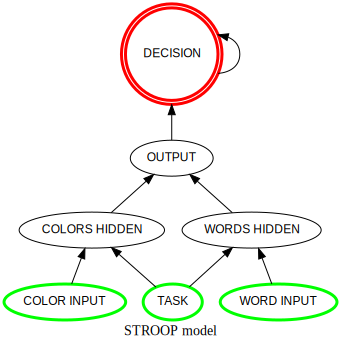

In [ ]:
model.show_graph(output_fmt = 'jupyter')

### 1.2 The task stimuli 

Again, we have two tasks: 
- color naming 
- word reading 

... and three conditions:

- control 
- conflict 
- congruent 

In [ ]:
"""define the inputs
i.e. all CONDITIONS x TASKS for the experiment
"""
# the length of the stimulus sequence
n_time_steps = 120
input_set = get_stimulus_set(inp_color, inp_word, inp_task, n_time_steps)

# show what's in the dictionary 
for task in TASKS: 
    print(f'{task}: {input_set[task].keys()}')

color naming: dict_keys(['control', 'conflict', 'congruent'])
word reading: dict_keys(['control', 'conflict', 'congruent'])


In [ ]:
# show one stimuli sequence 
task = 'color naming'
cond = 'conflict'
print(input_set[task][cond][inp_color].T)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]]


### 1.3 Run the model on all task - condition combinations

In [ ]:
"""run the model
test the model on all CONDITIONS x TASKS combinations
"""
# log the activities
hid_color.set_log_conditions('value')
hid_word.set_log_conditions('value')
output.set_log_conditions('value')

# run the model 
execution_id = 0
for task in TASKS:
    for cond in CONDITIONS:
        print(f'Running {task} - {cond} ... ')
        model.run(
            context=execution_id,
            inputs=input_set[task][cond],
            num_trials=n_time_steps,
        )
        execution_id += 1

Running color naming - control ... 


Output()

Running color naming - conflict ... 


Output()

Running color naming - congruent ... 


Output()

Running word reading - control ... 


Output()

Running word reading - conflict ... 


Output()

Running word reading - congruent ... 


Output()

In [ ]:
def get_log_values(execution_ids_):
    """
    get logged activity, given a list/array of execution ids
    """
    # word hidden layer
    hw_acts = np.array([
        np.squeeze(hid_word.log.nparray_dictionary()[ei]['value'])
        for ei in execution_ids_
    ])
    # color hidden layer
    hc_acts = np.array([
        np.squeeze(hid_color.log.nparray_dictionary()[ei]['value'])
        for ei in execution_ids_
    ])
    out_acts = np.array([
        np.squeeze(hid_color.log.nparray_dictionary()[ei]['value'])
        for ei in execution_ids_
    ])
    dec_acts = np.array([
        np.squeeze(model.parameters.results.get(ei))
        for ei in execution_ids_
    ])
    return hw_acts, hc_acts, out_acts, dec_acts

#### Collect the activity for all tasks x conditions 

In [ ]:
# collect the activity
ids = [ei for ei in range(execution_id)]
hw_acts, hc_acts, out_acts, dec_acts = get_log_values(ids)

print('activities: trial_id x n_time_steps x n_units')
print(f'word hidden: \t{np.shape(hw_acts)}')
print(f'color hidden: \t{np.shape(hc_acts)}')
print(f'output: \t{np.shape(out_acts)}')
print(f'decision acts: \t{np.shape(dec_acts)}')

activities: trial_id x n_time_steps x n_units
word hidden: 	(6, 120, 2)
color hidden: 	(6, 120, 2)
output: 	(6, 120, 2)
decision acts: 	(6, 120, 2)


## <a id='s2'>2. Visualize decision activity</a> 
[back to top](#table)

In this section, we will visualize the activity of the two decision units. For simplicity, the stimuli were intentionally chosen so that the correct response is always red (e.g. in a word naming - conflict trial, the word is red). Therefore, the activity for the red decision unit is always higher than the green decision unit. However, the difference between these two units depends on both task and condition. 

#### <a id='l1'> Lab Exercise 1: Setting Expectations </a>
Before looking at the results, predict which task-condition combination will evoke the biggest differences between the two decision units? Explain your reasoning.   Write your answer below.

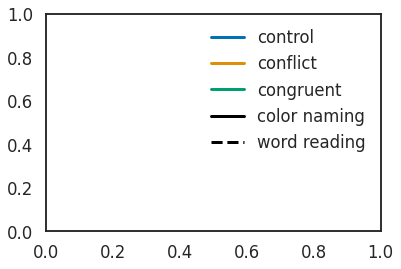

In [ ]:
"""
define the legend 
(this cell will output a figure legend, used subsequently, but no figure)
"""
# define the set of colors
col_pal = sns.color_palette('colorblind', n_colors=3)
# define the set of line style
lsty_plt = ['-', '--']
# line width
lw_plt = 3

lgd_elements = []
# legend for all conditions 
for i, cond in enumerate(CONDITIONS):
    lgd_elements.append(
        Line2D([0], [0], color=col_pal[i], lw=lw_plt, label=cond))

# legend for all tasks 
for i, task in enumerate(TASKS):
    lgd_elements.append(
        Line2D([0], [0], color='black', lw=lw_plt, label=task,
               linestyle=lsty_plt[i])
    )

# show the legend    
plt.legend(handles=lgd_elements, frameon=False)

### Plotting Response Unit Activity by Condition

The cell below creates a plot of decision unit activity over time for 3 different trial types.  For all trials, the ink color is red and the task is to respond to the ink color.  Control trials have no word.  Congruent trials display the word Red.  And Incongruent trials display the word Green.   In this figure, the top 3 lines show the Red Response Unit Activity, and these are higher because the stimulus is red ink and the task is to respond to the color of the ink.  The bottom 3 lines show the Green Response Unit Activity. 

For the incongruent color naming trial, the Red Response Unit is more active because the ink is red and the task is to respond to the ink color. However, the Green Response Unit (light blue line) is also somewhat active because the word is Green.  The relatively small (smaller than any other task-condition) difference between these two units suggests that the Decision Energy should be higher for this trial.

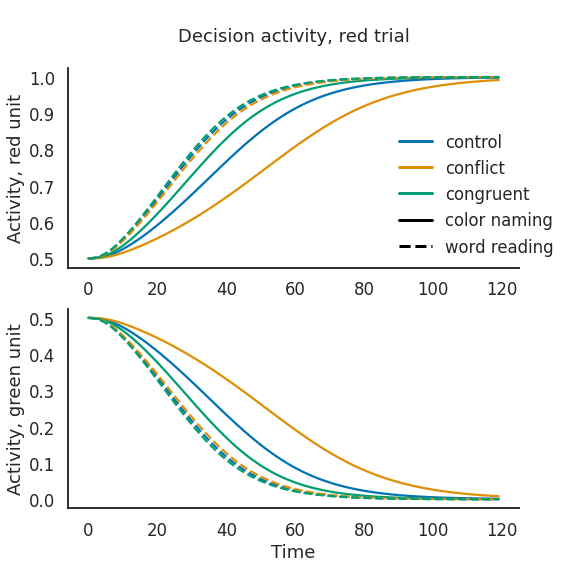

In [ ]:
"""plot the activity
"""

f, axes = plt.subplots(2, 1, figsize=(8, 8))
for j, task in enumerate(TASKS):
    for i, cond in enumerate(CONDITIONS):
        axes[0].plot(
            dec_acts[i + j*n_conditions][:, 0],
            color=col_pal[i], label=CONDITIONS[i], linestyle=lsty_plt[j],
        )
        axes[1].plot(
            dec_acts[i + j*n_conditions][:, 1],
            color=col_pal[i], linestyle=lsty_plt[j],
        )
        
title_text = """
Decision activity, red trial
"""
axes[0].set_title(title_text)
for i, ax in enumerate(axes):
    ax.set_ylabel(f'Activity, {COLORS[i]} unit')
axes[-1].set_xlabel('Time')
# add legend
axes[0].legend(
    handles=lgd_elements, frameon=False, bbox_to_anchor=(.7, .75)
)
f.tight_layout()
sns.despine()

#### <a id='l2'>Lab Exercise 2. Visualize the activity time course for the hidden layers on a green trial</a> 

2a. Plot the activity for the **color** hidden layer unit, for all tasks (color naming, word reading) x conditions (congruent, control, conflict).  Interpret the results.

2b. Plot the activity for the **word** hidden layer unit, for all tasks x conditions.  Interpret the results.

## <a id='s3'>3. Visualize Decision Energy</a> 
[back to top](#table)


<a href="https://en.wikipedia.org/wiki/Hopfield_network#Energy">Energy</a> 
is essentially the product of the two activation values.  For example, if the activations are at 0.6 and 0.4, the energy would be 0.24; in comparison to 0.1 and 0.9 computing an energy of 0.09.  This function is sensitive both to the total level of activation, and the differences between the units' activations.       
- This is also implemented in psyneulink as <a href="https://princetonuniversity.github.io/PsyNeuLink/Keywords.html?highlight=energy#psyneulink.core.globals.keywords.DistanceMetrics.ENERGY">pnl.ENERGY</a>. 

### Plotting Decision Energy
The following cell creates a plot of the decision energy for 3 types of trials: Control, Congruent, and Incongruent.  When the levels of activity for the two response units (Red & Green) are close, the decision energy is higher.  This makes sense because it is harder to decide when both responses are similarly active.  The decision is easiest (and energy is lowest) when the there is a big difference between the two response units.  

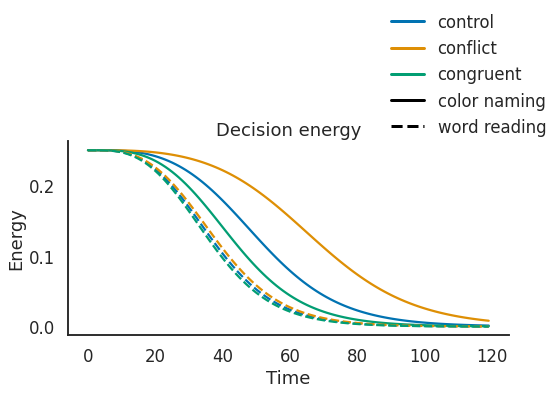

In [ ]:
"""
plot dec energy
"""
data_plt = dec_acts
f, ax = plt.subplots(1, 1, figsize=(8, 4))
col_pal = sns.color_palette('colorblind', n_colors=3)
counter = 0
for tid, task in enumerate(TASKS):
    for cid, cond in enumerate(CONDITIONS):
        ax.plot(
            np.prod(data_plt[counter], axis=1),
            color=col_pal[np.mod(counter, n_conditions)],
            linestyle=lsty_plt[tid]
        )
        counter += 1
        
ax.set_title(f'Decision energy')
ax.set_ylabel('Energy')
ax.set_xlabel('Time')
ax.legend(handles=lgd_elements, frameon=False, bbox_to_anchor=(.7, .95))
f.tight_layout()
sns.despine()

#### <a id='l3'>Lab Exercise 3: Energy, the initial state</a> 

Unpack what is being plotted by finding the equation used (e.g. in PNL documentation) and the input values to this calculation at the first time step.  What is the initial value of decision energy? Comment on why this is an interesting quantity for this situation. (Hint: What happens to the energy if one of the activation values is 1? What about if they are both equal?)

## <a id='s4'>4. Examine the effect of task demand</a> 
[back to top](#table)

#### Decision Energy as a Signal for Effort & Control

The simple model we have built so far shows one type of signal that could be monitored and used as input to a mechanism of effort and control.  For example, if Decision Energy is high, that could provide useful information that the task requires additional attention and/or effort.

In order to better understand the effects of modulating attention and/or effort in our models, it is helpful to explore exactly how these factors influence performance.  


In [ ]:
# re-initialize the model 
model, nodes, model_params = get_stroop_model(unit_noise_std, dec_noise_std)
[inp_color, inp_word, inp_task, hid_color, hid_word, output, decision] = nodes

# the length of the stimulus sequence
n_time_steps = 120
demand_levels = np.round(np.linspace(0, 1, 6), decimals=1)
n_demand_levels = len(demand_levels)
input_sets = [
    get_stimulus_set(inp_color, inp_word, inp_task, n_time_steps, demand=d)
    for d in demand_levels
]

print(f'demand levels: {demand_levels}')

demand levels: [0.  0.2 0.4 0.6 0.8 1. ]


In [ ]:
# run the model for all demand levels 
execution_id = 0
for did, demand in enumerate(demand_levels):
    for task in TASKS:
        time_start = time.time() #records start time, to estimate our progress
        print(f'\nWith demand = {demand}, running {task}: ', end='')
        for cond in CONDITIONS:
            print(f'{cond} ', end='')
            model.run(
                context=execution_id,
                inputs=input_sets[did][task][cond],
                num_trials=n_time_steps,
            )
            execution_id += 1
        print(f'| Time = %.2f'%(time.time()-time_start), end='')


With demand = 0.0, running color naming: control 

Output()

conflict 

Output()

congruent 

Output()

| Time = 14.81
With demand = 0.0, running word reading: control 

Output()

conflict 

Output()

congruent 

Output()

| Time = 15.70
With demand = 0.2, running color naming: control 

Output()

conflict 

Output()

congruent 

Output()

| Time = 15.68
With demand = 0.2, running word reading: control 

Output()

conflict 

Output()

congruent 

Output()

| Time = 15.83
With demand = 0.4, running color naming: control 

Output()

conflict 

Output()

congruent 

Output()

| Time = 16.30
With demand = 0.4, running word reading: control 

Output()

conflict 

Output()

congruent 

Output()

| Time = 16.16
With demand = 0.6, running color naming: control 

Output()

conflict 

Output()

congruent 

Output()

| Time = 16.36
With demand = 0.6, running word reading: control 

Output()

conflict 

Output()

congruent 

Output()

| Time = 16.44
With demand = 0.8, running color naming: control 

Output()

conflict 

Output()

congruent 

Output()

| Time = 16.41
With demand = 0.8, running word reading: control 

Output()

conflict 

Output()

congruent 

Output()

| Time = 16.51
With demand = 1.0, running color naming: control 

Output()

conflict 

Output()

congruent 

Output()

| Time = 16.86
With demand = 1.0, running word reading: control 

Output()

conflict 

Output()

congruent 

Output()

| Time = 16.82

In [ ]:
# collect the activity
ids = [ei for ei in range(execution_id)]

# get decision activities for all trials 
dec_acts = np.array([
    np.squeeze(model.parameters.results.get(ei))
    for ei in ids
])

In [ ]:
def compute_rt(act, threshold=.9):
    """compute reaction time
    take the activity of the decision layer...
    RT := the earliest time point when activity > threshold...
    """
    n_time_steps_, N_UNITS_ = np.shape(act)
    tps_pass_threshold = np.where(act[:, 0] > threshold)[0]
    if len(tps_pass_threshold) > 0:
        return tps_pass_threshold[0]
    return n_time_steps_

In [ ]:
# re-organize RT data
threshold = .9
rts = np.zeros((n_demand_levels, n_tasks, n_conditions))
counter = 0
for did, demand in enumerate(demand_levels):
    for tid, task in enumerate(TASKS):
        for cid, cond in enumerate(CONDITIONS):
            rts[did, tid, cid] = compute_rt(
                dec_acts[counter], threshold=threshold
            )
            counter += 1

### Plotting Task Demand & RT

The two figures created by the following cell qualitatively replicate Fig 13A (left) and Fig 13B (right) from <a href="https://www.ncbi.nlm.nih.gov/pubmed/2200075">Cohen et al. (1990)</a>.  The Y axis displays response time, and the X axis progresses upward in task demand unit activity.  (*Note that the key is consistent with previous figures in this notebook, but not all the conditions in the key are plotted.*) 

In the left panel we can see that Word reading (dashed black line) is generally faster than ink Color Naming (solid black line). The other prominent pattern is that increased activity in the task demand units leads to faster (lower) reaction times. 

The right panel compares Word reading under conflict (green dashed) to control (blue dashed).  It also displays part of the Color Naming plot under conflict (green solid).  These figures are truncated at the top to zoom in on key comparisons, and the full data extend well above the top of the Y-axis.    

These reaction times are in different units than human performance, but the overall trends make sense.  We can potentially use Task Demand as a way to model Attention/Effort. Increasing attention to the task improves performance yielding faster reaction times. 

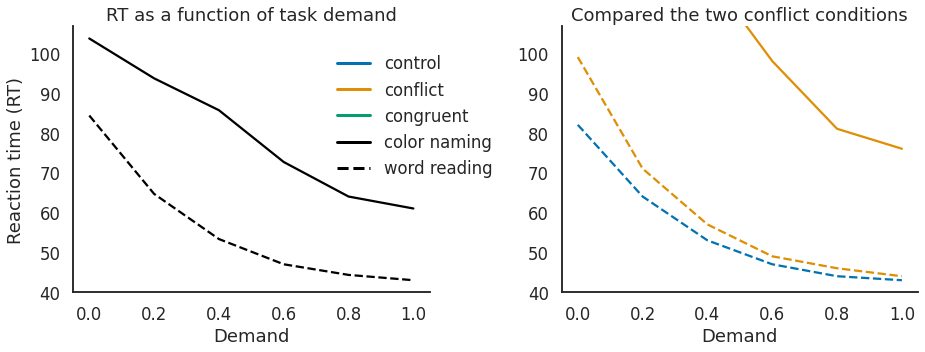

In [ ]:
# plot prep
col_pal = sns.color_palette('colorblind', n_colors=3)
xticklabels = ['%.1f' % (d) for d in demand_levels]

f, axes = plt.subplots(1, 2, figsize=(13, 5))
# left panel
axes[0].plot(np.mean(rts[:, 0, :], axis=1), color='black', linestyle='-')
axes[0].plot(np.mean(rts[:, 1, :], axis=1), color='black', linestyle='--')
axes[0].set_title('RT as a function of task demand')
# axes[0].legend(TASKS, frameon=False, bbox_to_anchor=(.4, 1))
axes[0].legend(handles=lgd_elements, frameon=False, bbox_to_anchor=(.7, .95))
# right panel
clf_id = 1
n_skips = 2
axes[1].plot(np.arange(n_skips, n_demand_levels, 1),
             rts[n_skips:, 0, clf_id], color=col_pal[clf_id],
             label='conflicting word')
axes[1].plot(rts[:, 1, clf_id], color=col_pal[clf_id],
             linestyle='--', label='conflicting color')
axes[1].plot(rts[:, 1, 0], color=col_pal[0], linestyle='--', label='control')
axes[1].set_title('Compared the two conflict conditions')
# axes[1].legend(frameon=False, bbox_to_anchor=(.55, 1))
# common
axes[0].set_ylabel('Reaction time (RT)')
axes[1].set_ylim(axes[0].get_ylim())
for ax in axes:
    ax.set_xticks(range(n_demand_levels))
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Demand')
f.tight_layout()
sns.despine()


#### <a id='l4'>Lab Exercise 4. Interpret the task demand results above </a>  
- Compare the results above with human performance in <a href="https://www.ncbi.nlm.nih.gov/pubmed/2200075">Cohen et al. (1990)</a> Figures 13A & 13B, and comment on a few interesting similarities and differences.  



#### <a id='h5'>Lab Exercise 5: Putting it all together</a> 

Note: Answers to this exercise can be qualitative and schematic -- you do not need to build the models (although you can if you like!), just describe how you would initially reason and plan to build them. 

5a.  How should task demand unit activity impact accuracy?

5b.  Concisely describe key elements of a model mimicking human performance that exhibits the appropriate influence of task demand activity on accuracy.

5c.  Describe steps that you could take, based on the models provided in this notebook, to build a model that monitors for conflict within trials and increases attention when conflict is present.  

5d.  Describe steps that you could take to build a model that monitors for errors after trials and increases attention on the subsequent trial.  




#### <a id='h5'> No BUILD this week, instead plan your projects! <a_id>